In [1]:
from wav2letter.models import Wav2LetterRF
from auditory_cortex.feature_extractors import FeatureExtractorW2L

import wav2letter

import torch
import yaml
import os
from scipy.io.wavfile import read


from transformers import Speech2TextFeatureExtractor
from optimal_input.hook import Hook
# from optimal_input.get_values import GetValues
# from auditory_cortex.dataset import Neural_Data
from auditory_cortex.regression import transformer_regression


/home/akamsali/anaconda3/envs/research/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sr, aud = read("/depot/jgmakin/data/audio_data/sent_0.wav")
feature_extractor = Speech2TextFeatureExtractor.from_pretrained("facebook/s2t-small-librispeech-asr")

data_dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
sub = '200206'
# dataset = Neural_Data(data_dir, sub)
reg = transformer_regression(data_dir, sub, load_features=False)

Creating dataset and other objects...
done


In [3]:
# get spikes
spikes = reg.all_channel_spikes(bin_width = 40, sents = [0])

In [4]:
# initialise model and layers

dir = os.getcwd()
conf_file = 'config_rf.yaml'
manifest_file = os.path.join(os.path.dirname(wav2letter.__file__),"conf",conf_file)
with open(manifest_file, 'r') as f:
    model_param = yaml.load(f, Loader=yaml.FullLoader)

checkpoint_file = "Wav2letter-epoch=024-val_loss=0.37.ckpt"
checkpoint = os.path.join(model_param["results_dir"],checkpoint_file)
model = Wav2LetterRF.load_from_checkpoint(checkpoint, manifest=model_param)

layers = ["conv" + str(x) for x in range(1, 16)]

In [6]:
# extract features for betas
extractor = FeatureExtractorW2L(model)
extractor.translate(aud)

tensor([[0.1307, 0.0125, 0.0159,  ..., 0.1200, 0.0265, 0.0535],
        [0.1308, 0.0000, 0.0378,  ..., 0.1008, 0.0289, 0.0486],
        [0.1300, 0.0000, 0.0311,  ..., 0.1029, 0.0278, 0.0534],
        ...,
        [0.1348, 0.0000, 0.0396,  ..., 0.1095, 0.0315, 0.0497],
        [0.1289, 0.0007, 0.0349,  ..., 0.1071, 0.0317, 0.0483],
        [0.1202, 0.0000, 0.0194,  ..., 0.0971, 0.0298, 0.0511]])

In [25]:
s = np.array([spikes[k] for k in range(len(spikes.keys()))])
s.shape

(64, 48)

In [43]:
# resample for betas
a = extractor.get_features(0)
a.shape

torch.Size([1531, 250])

In [44]:
import numpy as np 
from scipy import signal

sent = 0
bin_width = 40

n = spikes[0].shape[0]
resampled_features = signal.resample(a , n, axis=0)
resampled_features.shape

(48, 250)

In [45]:
def get_beta(z, n):
    return np.linalg.solve(z.T.dot(z), (z.T).dot(n))

betas = get_beta(resampled_features, s.T)
np.save("/depot/jgmakin/data/auditory_cortex/betas/w2l_l0.npy", betas, allow_pickle=True)

In [49]:
beta_l0 = np.load("/depot/jgmakin/data/auditory_cortex/betas/w2l_l0.npy", allow_pickle=True)
beta_l1 = np.load("/depot/jgmakin/data/auditory_cortex/betas/w2l_l1.npy", allow_pickle=True)

In [64]:
from optimal_input.opt_inp_w2l import GetOptInput

for param in model.parameters():
    param.requires_grad = False
get_opt_input = GetOptInput(model)

In [68]:
for i in range(64):
    get_opt_input.get_opt_input(torch.tensor(aud.astype('float32')).unsqueeze(0).T, layers[0], beta_l0[:, i].reshape(-1, 1).astype('float32'), iterations=100)
    # loss_l0.append(get_opt_input.loss_list)
    # spect_l0.append(get_opt_input.spect[0].detach().numpy().T)
    np.save(f'/depot/jgmakin/data/auditory_cortex/opt_inputs/layer_0_channel_{i}.npy', get_opt_input.aud.detach().numpy(), allow_pickle=True)

/tmp/ipykernel_172865/654575621.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.aud = torch.tensor(aud)


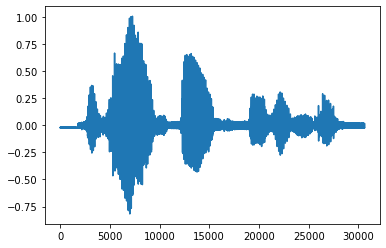

In [78]:
import matplotlib.pyplot as plt
opt_aud = get_opt_input.aud.detach().numpy()[:, 0]
# plt.plot()
sr, b = read("/depot/jgmakin/data/audio_data/sent_0.wav")

plt.plot(opt_aud)

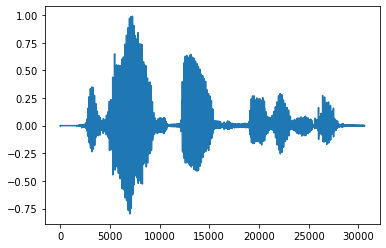

In [79]:
plt.plot(b)

In [ ]:
a = dataset.retrieve_spike_counts(sent=0, win=1.9)
a[0].shape